In [2]:
### Setup Environment ###
import numpy as np
import pandas as pd
import plotly_express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import chi2_contingency
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from itertools import combinations

np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.4f}'.format})
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', None)

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, f_classif, SelectKBest, SelectFromModel, SequentialFeatureSelector
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('matchups_womens_laterounds.csv')
print(df.shape)
df.head()

(49, 49)


,game_id,year,round,region,high_team_id,low_team_id,win,ppg,opp_ppg,net_ppg,...,3prd,%pts_ftd,%pts_2pd,%pts_3pd,astd%,tovd%,opp_ast_tov,opp_stl%,opp_blk%,opp_pf%
0,20174115,2017,Elite Eight,East,2017 Connecticut,2017 Oregon,1,21.3000,-16.0000,27.1000,...,0.0750,0.0430,0.0050,0.0470,-0.1280,0.0410,-0.5900,-0.0090,-0.0050,0.0080
1,20174215,2017,Elite Eight,West,2017 South Carolina,2017 Florida St.,1,18.0000,-22.1000,-1.2000,...,0.0470,0.0180,0.0170,0.0360,-0.0230,0.0220,-0.3600,-0.0550,-0.0340,0.0270
2,20174315,2017,Elite Eight,South,2017 Notre Dame,2017 Stanford,0,23.6000,-9.4000,2.6000,...,0.0370,0.0220,0.0380,0.0600,0.0160,0.0280,-0.2500,-0.0170,-0.0750,0.0280
3,20174415,2017,Elite Eight,Midwest,2017 Baylor,2017 Mississippi St.,0,31.9000,-19.6000,14.9000,...,0.0700,0.0080,0.0960,0.0880,-0.0310,0.0250,-0.5000,-0.0510,-0.0450,-0.0240
4,20175516,2017,Final Four,Final Four,2017 Connecticut,2017 Mississippi St.,0,29.5000,-21.0000,13.9000,...,0.0910,0.0910,0.0030,0.0920,-0.0480,0.0640,-0.5700,-0.0290,-0.0320,-0.0330


In [3]:
df['win'].value_counts(normalize=True)

1   0.6531
0   0.3469
Name: win, dtype: float64

In [4]:
df.columns

Index(['game_id', 'year', 'round', 'region', 'high_team_id', 'low_team_id',
       'win', 'ppg', 'opp_ppg', 'net_ppg', 'off_rtg', 'def_rtg', 'net_rtg',
       'pace', 'hhs_net_rtg', 'hhs_off_rtg', 'hhs_def_rtg', 'rpi', 'ppp',
       'ppsa', 'efg%', 'ftr', '3pr', '%pts_ft', '%pts_2p', '%pts_3p', 'orb%',
       'drb%', 'trb%', 'ast%', 'tov%', 'ast_tov', 'stl%', 'blk%', 'pf%',
       'pppd', 'opp_ppsa', 'efgd%', 'ftrd', '3prd', '%pts_ftd', '%pts_2pd',
       '%pts_3pd', 'astd%', 'tovd%', 'opp_ast_tov', 'opp_stl%', 'opp_blk%',
       'opp_pf%'],
      dtype='object')

In [5]:
eda_df = df[[
    'win', 'ppg', 'opp_ppg', 'net_ppg', 'off_rtg', 'def_rtg', 'net_rtg',
       'pace', 'hhs_net_rtg', 'hhs_off_rtg', 'hhs_def_rtg', 'rpi', 'ppp',
       'ppsa', 'efg%', 'ftr', '3pr', '%pts_ft', '%pts_2p', '%pts_3p', 'orb%',
       'drb%', 'trb%', 'ast%', 'tov%', 'ast_tov', 'stl%', 'blk%', 'pf%',
       'pppd', 'opp_ppsa', 'efgd%', 'ftrd', '3prd', '%pts_ftd', '%pts_2pd',
       '%pts_3pd', 'astd%', 'tovd%', 'opp_ast_tov', 'opp_stl%', 'opp_blk%',
       'opp_pf%']]

In [6]:
# Split dataset into a train and test set
X = eda_df.drop('win', axis=1)
Y = eda_df['win']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print(train_df.shape)
print(test_df.shape)

(34, 43)
(15, 43)


### I. Numerical Tests

In [7]:
corr_matrix = train_df.corr()
correlation_with_target = round(abs(corr_matrix['win'])*100,2)
correlation_with_target = correlation_with_target[correlation_with_target >= 10]
print(correlation_with_target)

net_ppg        47.1400
def_rtg        19.1300
net_rtg        46.4200
pace           12.9400
hhs_net_rtg    50.5500
hhs_def_rtg    14.0500
rpi            58.3900
ppp            12.2600
ppsa           13.2600
ftr            27.9200
%pts_ft        31.5100
%pts_2p        17.2500
%pts_3p        19.2700
orb%           29.0700
trb%           35.1300
blk%           39.1200
pf%            19.2400
pppd           19.2300
opp_ppsa       29.9700
efgd%          26.2800
ftrd           11.3600
%pts_2pd       22.6700
%pts_3pd       13.9900
astd%          19.2600
tovd%          33.8000
opp_stl%       14.3300
opp_blk%       21.9800
opp_pf%        39.8600
win           100.0000
Name: win, dtype: float64


In [8]:
X = train_df.drop('win', axis=1)
y = train_df['win']

# ANOVA
f_values, p_values = f_classif(X, y)
# Mutual Information
mi = mutual_info_regression(X, y)

column_names = np.array(X.columns)
stats_df = pd.DataFrame({
    'feature': column_names,
    'f_values': f_values,
    'p_values': p_values,
    'mutual_info': mi
})
stats_df

,feature,f_values,p_values,mutual_info
0,ppg,0.0458,0.8319,0.0997
1,opp_ppg,0.2589,0.6144,0.0922
2,net_ppg,9.1446,0.0049,0.1402
3,off_rtg,0.0299,0.8639,0.0000
4,def_rtg,1.2153,0.2785,0.0000
5,net_rtg,8.7898,0.0057,0.1482
6,pace,0.5447,0.4659,0.0025
7,hhs_net_rtg,10.9807,0.0023,0.2328
8,hhs_off_rtg,0.0446,0.8341,0.0000
9,hhs_def_rtg,0.6446,0.4280,0.0000


In [9]:
stats_df[stats_df['mutual_info'] > .05]

,feature,f_values,p_values,mutual_info
0,ppg,0.0458,0.8319,0.0997
1,opp_ppg,0.2589,0.6144,0.0922
2,net_ppg,9.1446,0.0049,0.1402
5,net_rtg,8.7898,0.0057,0.1482
7,hhs_net_rtg,10.9807,0.0023,0.2328
10,rpi,16.5538,0.0003,0.1563
14,ftr,2.7046,0.1098,0.1021
21,trb%,4.5064,0.0416,0.1470
23,tov%,0.0032,0.9553,0.0851
26,blk%,5.7815,0.0222,0.0698


In [10]:
stats_df[stats_df['p_values'] < .05]

,feature,f_values,p_values,mutual_info
2,net_ppg,9.1446,0.0049,0.1402
5,net_rtg,8.7898,0.0057,0.1482
7,hhs_net_rtg,10.9807,0.0023,0.2328
10,rpi,16.5538,0.0003,0.1563
21,trb%,4.5064,0.0416,0.1470
26,blk%,5.7815,0.0222,0.0698
41,opp_pf%,6.0440,0.0195,0.0260


In [11]:
stats_df[stats_df['f_values'] > 5]

,feature,f_values,p_values,mutual_info
2,net_ppg,9.1446,0.0049,0.1402
5,net_rtg,8.7898,0.0057,0.1482
7,hhs_net_rtg,10.9807,0.0023,0.2328
10,rpi,16.5538,0.0003,0.1563
26,blk%,5.7815,0.0222,0.0698
41,opp_pf%,6.0440,0.0195,0.0260


### II. Wrapper Methods

In [12]:
X_train = train_df.drop('win', axis=1)
y_train = train_df['win']

X_test = test_df.drop('win', axis=1)
y_test = test_df['win']

float64_columns = X_train.select_dtypes(include=['float64']).columns

scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_train_scaled[float64_columns] = scaler.fit_transform(X_train[float64_columns])

X_test_scaled = X_test.copy()
X_test_scaled[float64_columns] = scaler.transform(X_test[float64_columns])

In [13]:
sel_ = SelectFromModel(
    LogisticRegression(C=0.5, penalty='l1', solver='liblinear', random_state=10))

sel_.fit(X_train_scaled, y_train)

SelectFromModel(estimator=LogisticRegression(C=0.5, penalty='l1',
                                             random_state=10,
                                             solver='liblinear'))

In [14]:
selected_feat = X_train.columns[(sel_.get_support())]

print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
    np.sum(sel_.estimator_.coef_ == 0)))

total features: 42
selected features: 9
features with coefficients shrank to zero: 33


In [15]:
# Transform datasets based on selected features
X_train_selected = sel_.transform(X_train_scaled)
X_test_selected = sel_.transform(X_test_scaled)

# Train a Lasso regression model
lasso = Lasso(alpha=0.1, random_state=42)
lasso.fit(X_train_selected, y_train)

# Make predictions
y_train_pred = lasso.predict(X_train_selected)
y_test_pred = lasso.predict(X_test_selected)

# Convert predictions to binary using a threshold
threshold = 0.5
y_train_pred_binary = (y_train_pred >= threshold).astype(int)
y_test_pred_binary = (y_test_pred >= threshold).astype(int)

# Evaluate F1 scores
f1_train = f1_score(y_train, y_train_pred_binary)
f1_test = f1_score(y_test, y_test_pred_binary)

print(f"Lasso Regression F1 Score (Train): {f1_train:.2f}")
print(f"Lasso Regression F1 Score (Test): {f1_test:.2f}")

Lasso Regression F1 Score (Train): 0.89
Lasso Regression F1 Score (Test): 0.82


In [16]:
selected_feat

Index(['net_ppg', 'rpi', '%pts_ft', '%pts_2p', '%pts_3p', 'blk%', 'ftrd',
       '%pts_2pd', 'opp_pf%'],
      dtype='object')

In [17]:
sfs = SequentialFeatureSelector(
        estimator=RandomForestClassifier(
        n_estimators=10, n_jobs=4, random_state=0),
        n_features_to_select=10,  # the number of features to retain
        direction='backward',  # the direction of the selection procedure
        scoring='roc_auc',  # the metric to evaluate
        cv=2, # the cross-validation fold
        n_jobs=None
)


sfs = sfs.fit(X_train, y_train)

In [18]:
def run_randomForests(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=3)
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [19]:
selected_feat= sfs.get_feature_names_out()
selected_feat

array(['opp_ppg', 'pace', 'rpi', 'ppp', 'efg%', '%pts_ft', 'orb%',
       'ast_tov', 'opp_ppsa', 'astd%'], dtype=object)

In [20]:
run_randomForests(X_train[selected_feat],
                  X_test[selected_feat],
                  y_train, y_test)

Train set
Random Forests roc-auc: 1.0
Test set
Random Forests roc-auc: 0.5599999999999999


In [21]:
run_randomForests(X_train,
                  X_test,
                  y_train, y_test)

Train set
Random Forests roc-auc: 1.0
Test set
Random Forests roc-auc: 0.43999999999999995


In [22]:
roc_values = []

# iterate over each feature in the dataset
for feature in X_train.columns:

    # train a decision tree classifier
    clf = DecisionTreeClassifier(random_state=0)
    clf.fit(X_train[feature].fillna(0).to_frame(), y_train)

    # obtain the predictions
    y_scored = clf.predict_proba(X_test[feature].to_frame())

    # calculate and store the roc-auc
    roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))
    
# display the result
roc_values

[0.6500000000000001,
 0.36,
 0.38,
 0.45999999999999996,
 0.5700000000000001,
 0.39999999999999997,
 0.63,
 0.7,
 0.45000000000000007,
 0.45999999999999996,
 0.8,
 0.44,
 0.43999999999999995,
 0.5499999999999999,
 0.65,
 0.49,
 0.41999999999999993,
 0.5399999999999999,
 0.56,
 0.52,
 0.55,
 0.5499999999999999,
 0.58,
 0.5700000000000001,
 0.35,
 0.37,
 0.5,
 0.5,
 0.78,
 0.51,
 0.46,
 0.45000000000000007,
 0.48,
 0.4099999999999999,
 0.46,
 0.35,
 0.39999999999999997,
 0.39999999999999997,
 0.25,
 0.5,
 0.3,
 0.6]

Text(0, 0.5, 'roc-auc')

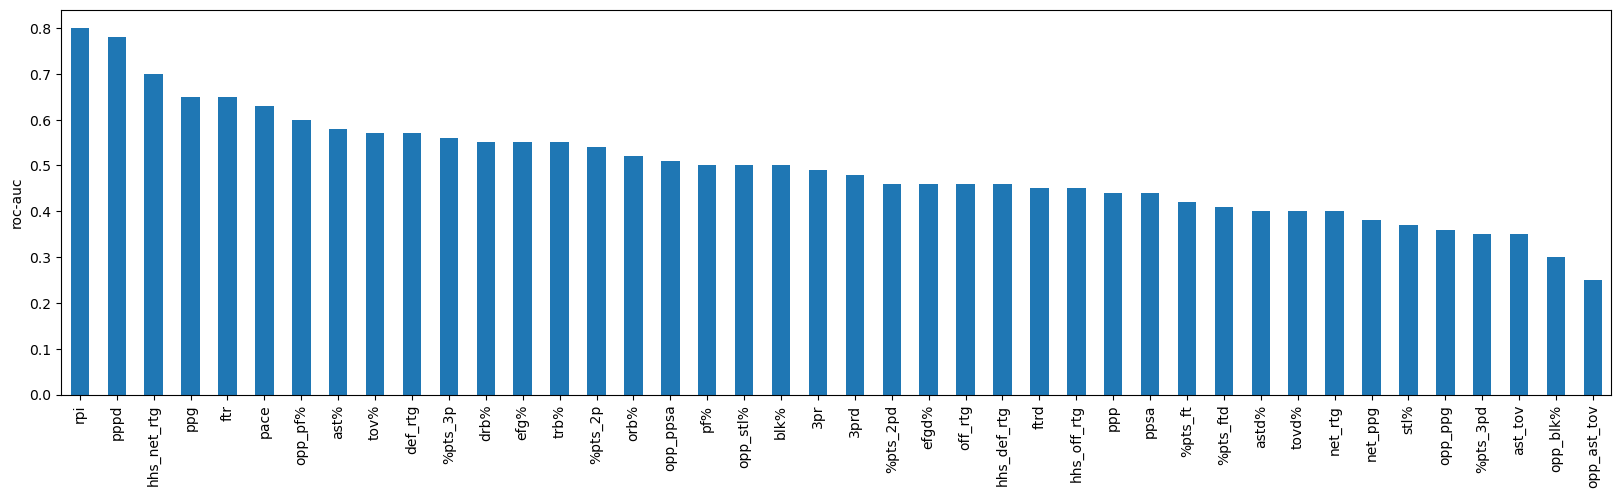

In [23]:
roc_values = pd.Series(roc_values)
roc_values.index = X_train.columns
roc_values.sort_values(ascending=False).plot.bar(figsize=(20, 5))
plt.ylabel('roc-auc')

In [24]:
len(roc_values[roc_values > 0.6])

6

In [25]:
roc_values[roc_values > 0.6]

ppg           0.6500
pace          0.6300
hhs_net_rtg   0.7000
rpi           0.8000
ftr           0.6500
pppd          0.7800
dtype: float64

In [44]:
X_train_scaled2 = X_train_scaled[[
 'net_ppg', 'rpi', '%pts_ft', '%pts_2p', '%pts_3p', 'blk%', 'ftrd',
       '%pts_2pd', 'opp_pf%'
]]

X_test_scaled2 = X_test_scaled[[
 'net_ppg', 'rpi', '%pts_ft', '%pts_2p', '%pts_3p', 'blk%', 'ftrd',
       '%pts_2pd', 'opp_pf%'
]]

In [45]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# Set up hyperparameter grid
param_grid = {
    'max_depth': [2, 3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200, 300, 400, 500, 1000],
    'subsample': [0.1, 0.2, 0.3, 0.4],
    'colsample_bytree': [0.3, 0.4, 0.5, 0.6],
    'gamma': [0.2, 0.3, 0.4]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='neg_log_loss', cv=5, verbose=1, n_jobs=-1)

# Fit grid search
grid_search.fit(X_train_scaled2, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

Fitting 5 folds for each of 2880 candidates, totalling 14400 fits
Best Hyperparameters: {'colsample_bytree': 0.4, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 1000, 'subsample': 0.4}


In [46]:
# Retrain the model with the best parameters
best_xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    **best_params
)

best_xgb_model.fit(X_train_scaled2, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.2, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [47]:
# Predict probabilities
y_pred_proba = best_xgb_model.predict_proba(X_test_scaled2)[:, 1]

# Calculate Log Loss
logloss = log_loss(y_test, y_pred_proba)
print(f"Log Loss on test set: {logloss}")

Log Loss on test set: 0.7906460754978466


In [48]:
# Predictions
y_train_pred = best_xgb_model.predict(X_train_scaled2)
y_test_pred = best_xgb_model.predict(X_test_scaled2)

# Calculate accuracy scores
f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)

print(f"F1 Score on Training Data: {f1_train:.2f}")
print(f"F1 Score on Test Data: {f1_test:.2f}")

F1 Score on Training Data: 0.96
F1 Score on Test Data: 0.56


<Figure size 1000x600 with 0 Axes>

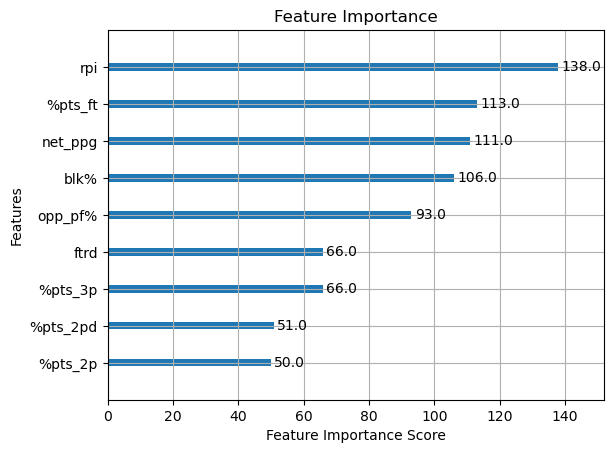

In [49]:
from xgboost import plot_importance

# Extract feature importance
feature_importance = best_xgb_model.get_booster().get_score(importance_type='weight')

# Visualize feature importance
plt.figure(figsize=(10, 6))
plot_importance(best_xgb_model, importance_type='weight', show_values=True, xlabel='Feature Importance Score')
plt.title('Feature Importance')
plt.show()
